<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/EfficientNet_age_sex_crossvalidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


#**Evaluator**

In [17]:
import os
import random
import numpy as np
import glob
import torch
from torch.utils.data import Dataset
from PIL import Image
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class Evaluator:
    def __init__(self, model, classes, age_dict, sex_dict, val_folder_path, val_transform, device, print_round_num=2) -> None:
        super().__init__()
        self.model = model
        self.val_folder_path = val_folder_path
        self.val_transform = val_transform
        self.device = device
        self.print_round_num = print_round_num
        
        self.class_names = classes
        self.age_dict = age_dict
        self.sex_dict = sex_dict
        self.image_paths = glob.glob(self.val_folder_path + "/*/*")
        print('eval number of classes: ' +str(len(self.class_names)))
        print('eval number of images: ' +str(len(self.image_paths)))
        random.shuffle(self.image_paths) 

        self.max_accuracy = 0
        # to update self.max_accuracy
        self.evaluate()
        print("initial accuracy: " + str(self.max_accuracy))

    def evaluate(self):
        TP = FP = TN = FN = TP = FP = TN = FN = 0
        image_name_list = []
        label_list = []
        model_pred_list = []

        model_pred_class = []
        model_pred_prob = []

        for image_path in self.image_paths:
            image_name, label, age, sex = self.get_label(image_path)
            if np.isnan(age):
                    continue
            image_tensor = self.get_image_tensor(image_path)

            is_training = self.model.training
            self.model.eval()
            with torch.no_grad():
                output = self.model(image_tensor)
            if is_training:
                self.model.train()
                
            output = output.squeeze(0)
            #model_pred:クラス名前、prob:確率、pred:クラス番号
            prob = torch.clamp(output[0], 0, 1)
            pred = int(torch.round(prob))
            model_pred = self.class_names[pred]
            
            image_name_list.append(image_name)
            label_list.append(label)
            model_pred_list.append(model_pred)

            model_pred_class.append(int(pred))
            model_pred_prob.append(float(prob))

            if label == self.class_names[0]:
                if model_pred == self.class_names[0]:
                    TN += 1
                else:
                    FP += 1
            elif label == self.class_names[1]:
                if model_pred == self.class_names[1]:
                    TP += 1
                else:
                    FN += 1

        accuracy, precision, recall, specificity, f_value = self.calculate_accuracy(TP, TN, FP, FN)
        is_best = self.max_accuracy < accuracy
        if is_best:
            self.max_accuracy = accuracy

        return is_best, (round(accuracy, self.print_round_num), 
            round(precision, self.print_round_num), 
            round(recall, self.print_round_num), 
            round(specificity, self.print_round_num), 
            round(f_value, self.print_round_num))
        
    def draw_roc(self, output_path):
        label_list = []
        model_pred_prob = []

        for image_path in self.image_paths:
            image_name, label, age, sex = self.get_label(image_path)
            image_tensor = self.get_image_tensor(image_path)

            is_training = self.model.training
            self.model.eval()
            with torch.no_grad():
                output = self.model(image_tensor)
            if is_training:
                self.model.train()
                
            output = output.squeeze(0)
            #model_pred:クラス名前、prob:確率、pred:クラス番号
            prob = torch.clamp(output[0], 0, 1)

            label_list.append(label)
            model_pred_prob.append(float(prob))

        y_score = []
        y_true = []

        k=0
        for i in label_list:
            if label_list[k] == 'cont':
                y_true.append(0)
            elif label_list[k] == 'grav':
                y_true.append(1)
            k+=1

        #健康な状態を「0」、病気を「1」としてラベルよりリストを作成
        y_true = y_true
        #それぞれの画像における陽性の確率についてリストを作成
        y_score = model_pred_prob
        try:
            fpr, tpr, thred = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            lw = 2
            plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic example')
            plt.legend(loc="lower right")
            plt.savefig(output_path)
        except:
            pass

    #対象のパスからラベルを抜き出す
    def get_label(self, image_path):
        image_name = os.path.basename(image_path)
        
        base_name, ext = os.path.splitext(image_name)
        age = float(self.age_dict[base_name]) / 100
        sex = float(self.sex_dict[base_name])
        
        label = os.path.basename(os.path.dirname(image_path))
        return(image_name, label, age, sex)
        
    def get_image_tensor(self, image_path):    
        image = Image.open(image_path).convert("RGB")
        image_tensor = self.val_transform(image)
        image_tensor.unsqueeze_(0)
        image_tensor = image_tensor.to(self.device) 
        return(image_tensor)
        
    def calculate_accuracy(self, TP, TN, FP, FN):
        try:
            accuracy = (TP + TN)/ (TP + TN + FP + FN)
            precision  = TP/(FP + TP)
            recall = TP/(TP + FN)
            specificity = TN/(FP + TN)
            f_value = (2*recall*precision)/(recall+precision)
        except:
            accuracy = -1
            precision  = -1
            recall = -1
            specificity = -1
            f_value = -1
        return(accuracy, precision, recall, specificity, f_value)

#**Train**

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0
train_dataset_size：531
eval number of classes: 2
eval number of images: 134
initial accuracy: 0


  0%|          | 0/5 [00:00<?, ?it/s]

-----
(-1, -1, -1, -1, -1)
max_accuracy: 0
-----
(-1, -1, -1, -1, -1)
max_accuracy: 0
-----
(0.56, 0.85, 0.16, 0.97, 0.28)
max_accuracy: 0.5639097744360902
-----
(0.58, 0.79, 0.22, 0.94, 0.35)
max_accuracy: 0.5789473684210527


 20%|██        | 1/5 [00:24<01:39, 24.97s/it]

-----
(0.6, 0.89, 0.24, 0.97, 0.38)
max_accuracy: 0.6015037593984962
-----
(0.61, 0.86, 0.27, 0.95, 0.41)
max_accuracy: 0.6090225563909775
-----
(0.65, 0.83, 0.37, 0.92, 0.52)
max_accuracy: 0.6466165413533834
-----
(0.6, 0.89, 0.24, 0.97, 0.38)
max_accuracy: 0.6466165413533834


 40%|████      | 2/5 [00:52<01:16, 25.59s/it]

-----
(0.56, 0.9, 0.13, 0.98, 0.23)
max_accuracy: 0.6466165413533834
-----
(0.56, 0.9, 0.13, 0.98, 0.23)
max_accuracy: 0.6466165413533834
-----
(0.6, 0.85, 0.25, 0.95, 0.39)
max_accuracy: 0.6466165413533834
-----
(0.7, 0.89, 0.46, 0.94, 0.61)
max_accuracy: 0.6992481203007519


 60%|██████    | 3/5 [01:13<00:48, 24.28s/it]

-----
(0.69, 0.86, 0.46, 0.92, 0.6)
max_accuracy: 0.6992481203007519
-----
(0.64, 0.91, 0.31, 0.97, 0.47)
max_accuracy: 0.6992481203007519
-----
(0.65, 0.92, 0.34, 0.97, 0.5)
max_accuracy: 0.6992481203007519
-----
(0.74, 0.83, 0.6, 0.88, 0.7)
max_accuracy: 0.7368421052631579


 80%|████████  | 4/5 [01:34<00:23, 23.31s/it]

-----
(0.8, 0.81, 0.78, 0.82, 0.79)
max_accuracy: 0.7969924812030075
-----
(0.77, 0.84, 0.69, 0.86, 0.75)
max_accuracy: 0.7969924812030075
-----
(0.74, 0.83, 0.6, 0.88, 0.7)
max_accuracy: 0.7969924812030075
-----
(0.73, 0.82, 0.6, 0.86, 0.69)
max_accuracy: 0.7969924812030075


100%|██████████| 5/5 [01:56<00:00, 23.34s/it]


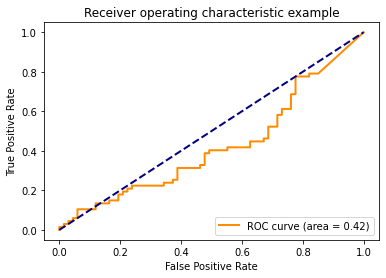

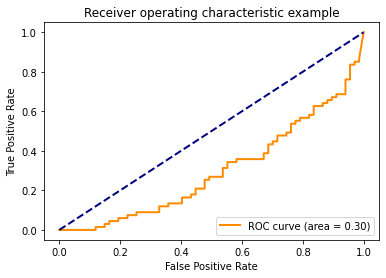

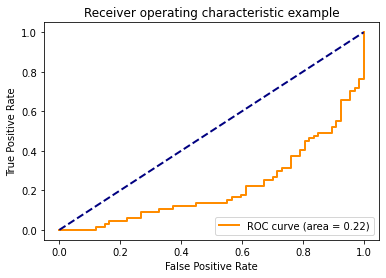

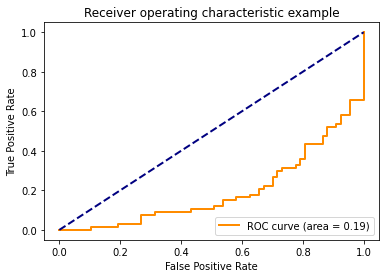

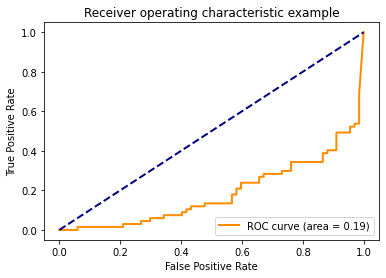

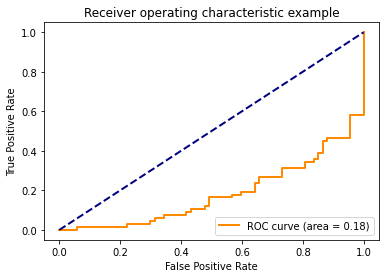

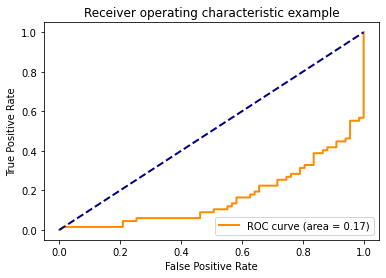

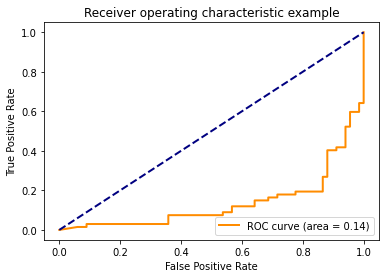

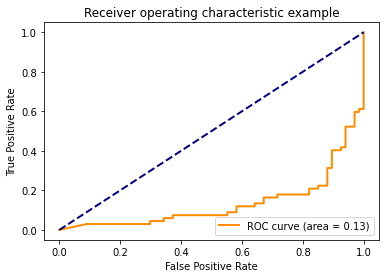

In [18]:
##########
# Usage
#   python train_grav_multi.py
##########
# ├─gravcont_250px_cross
# │   ├─train
# │   │  ├─cont
# │   │  └─grav
# │   └─val
# │       ├─cont
# │       └─grav


import os
import random
import json
import tqdm
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import folder
import torchvision.transforms as transforms
import torchvision.datasets as datasets
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet 


# change working directory
path = '/content/drive/MyDrive/Deep_learning/666mai_dataset'
os.chdir(path)

# grav or cont, age, and sex
NUM_CLASSES = 3
# contains train, val
#DATASET_PATH = r"./crossvalidation_250px/0/"
DATASET_PATH = r"./gravcont_250px_cross/"
TEST_PATH = r"./crossvalidation_250px/test/"
TRAIN_FOLDER_NAME = "train"
VAL_FOLDER_NAME = "val"
EFFICIENT_NET_NAME = "efficientnet-b0"
MODEL_PATH = "./model_multi.pth"
OPTIMIZER_PATH = "./optimizer_multi.pth"
SEX_DICT_PATH = "gender_json"
AGE_DICT_PATH = "age_json"
LOG_PATH = "./log_multi.txt"
ROC_PATH = "./roc_multi.png"
CHECKPOINT_COUNT = 10
EPOCH = 100
BATCH_SIZE = 16

# transforms param
PX = 224
TRAIN_NORMALIZE_PARAM = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
TRAIN_CROP_SCALE =(0.75,1.0)
TRAIN_BRIGHTNESS_PARAM = 0.2
TRAIN_CONTRAST_PARAM = 0.1
TRAIN_SATURATION_PARAM = 0.1
TRAIN_RANDOM_ROTATION = 3
TRAIN_HUE_PARAM = 0.02
VAL_NORMALIZE_PARAM = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

#######
# Set random seem for reproducibility
manualSeed = 1234
# print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
#######

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

age_dict = []
with open(AGE_DICT_PATH, "r") as f:
        age_dict = json.load(f)
sex_dict = []
with open(SEX_DICT_PATH, "r") as f:
        sex_dict = json.load(f)
        
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, age_dict, sex_dict, transform):
        self.transform = transform
        self.class_names = os.listdir(folder_path)
        self.item_paths = []
        self.item_dict = {}
        for class_num in range(len(self.class_names)):
                class_name = self.class_names[class_num]
                class_path = os.path.join(folder_path, class_name)
                for image_name in os.listdir(class_path):
                        base_name, ext = os.path.splitext(image_name)
                        if np.isnan(age_dict[base_name]):
                                continue
                        age = float(age_dict[base_name]) / 100
                        sex = float(sex_dict[base_name])
                        image_path = os.path.join(class_path, image_name)
                        self.item_paths.append(image_path)
                        self.item_dict[image_path] = (class_num, age, sex)

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        class_num, age, sex = self.item_dict[image_path]
        class_num = torch.tensor(class_num)
        age = torch.tensor(age)
        sex = torch.tensor(sex)
        label = torch.tensor([class_num, age, sex])
        return tensor_image, label

if __name__ == "__main__":
        if os.path.exists(MODEL_PATH):
                model = EfficientNet.from_pretrained(EFFICIENT_NET_NAME, MODEL_PATH, num_classes=NUM_CLASSES)
        else:
                model = EfficientNet.from_pretrained(EFFICIENT_NET_NAME, num_classes=NUM_CLASSES)
        model.train()
        model.to(device)

        # transforms自体を定数として上に記述しても良いかもしれません
        train_data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=TRAIN_BRIGHTNESS_PARAM, contrast=TRAIN_CONTRAST_PARAM,
                 saturation=TRAIN_SATURATION_PARAM, hue=TRAIN_HUE_PARAM),
                # transforms.RandomRotation((-TRAIN_RANDOM_ROTATION, TRAIN_RANDOM_ROTATION)),
                transforms.ToTensor(),
                transforms.Normalize(TRAIN_NORMALIZE_PARAM[0], TRAIN_NORMALIZE_PARAM[1])])
        val_data_transforms = transforms.Compose([
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize(VAL_NORMALIZE_PARAM[0], VAL_NORMALIZE_PARAM[1])])                
                
        train_dataset = SimpleImageDataset(os.path.join(DATASET_PATH, TRAIN_FOLDER_NAME), age_dict, sex_dict, train_data_transforms)
        train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
        print(TRAIN_FOLDER_NAME + "_dataset_size：" + str(len(train_dataset)))

        optimizer = torch.optim.AdamW(model.parameters(), 0.0002)
        if os.path.exists(OPTIMIZER_PATH):
                optimizer.load_state_dict(torch.load(OPTIMIZER_PATH))

        loss_func = torch.nn.MSELoss()
        
        val_folder_path = os.path.join(DATASET_PATH, VAL_FOLDER_NAME)
        evaluator = Evaluator(model, train_dataset.class_names, age_dict, sex_dict, val_folder_path, val_data_transforms, device)
        evaluator.draw_roc(ROC_PATH)

        for epoch in tqdm.tqdm(range(EPOCH)):
                for (i, batch) in enumerate(train_dataloader):
                        optimizer.zero_grad()

                        inputs, labels = batch
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        
                        outputs = model(inputs)

                        loss = loss_func(outputs, labels)
                        loss.backward()
                        optimizer.step()

                        if i % CHECKPOINT_COUNT == 0:
                                is_best, score = evaluator.evaluate()
                                if is_best:
                                        evaluator.draw_roc(ROC_PATH)
                                        torch.save(model.state_dict(), MODEL_PATH)
                                        torch.save(optimizer.state_dict(), OPTIMIZER_PATH)

                                # write log to file
                                with open(LOG_PATH, 'a') as f:
                                        f.write("-----")
                                        f.write("\n")
                                        f.write("batch_size: " + str(BATCH_SIZE))
                                        f.write("\n")
                                        f.write("iter: " + str(epoch * len(train_dataloader) + i))
                                        f.write(str(score))
                                        f.write("\n")
                                
                                # print log
                                print("-----")
                                print(score)
                                print("max_accuracy: " + str(evaluator.max_accuracy))




eval number of classes: 2
eval number of images: 86
initial accuracy: 0.8705882352941177
(0.87, 0.92, 0.81, 0.93, 0.86)


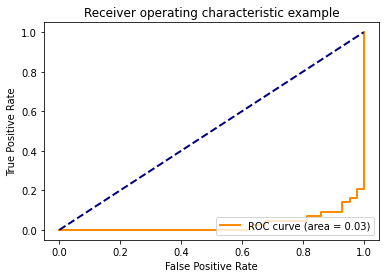

In [25]:
        #ここからevalation                        
        model.eval()

        test_dataset = SimpleImageDataset(TEST_PATH, age_dict, sex_dict, train_data_transforms)
        test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

        test_folder_path = TEST_PATH
        evaluator = Evaluator(model, test_dataset.class_names, age_dict, sex_dict, test_folder_path, val_data_transforms, device)
        
        _ ,score =evaluator.evaluate()
        print(score)

        evaluator.draw_roc(ROC_PATH)